In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import kagglehub
import seaborn as sbn
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from keras.activations import relu, softmax, sigmoid, tanh, swish, elu
from keras.layers import Dense, Input, Flatten, Reshape, RandomBrightness, Dropout, ReLU, Normalization, BatchNormalization, MaxPool2D, MaxPool1D
from keras.datasets import mnist
from keras.optimizers import Adam, SGD, RMSprop
from keras.optimizers.schedules import ExponentialDecay, PolynomialDecay, PiecewiseConstantDecay, CosineDecay, CosineDecayRestarts, InverseTimeDecay
from keras.models import Sequential, Model
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from keras.regularizers import l2, l1
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.initializers import Zeros, GlorotNormal, GlorotUniform, HeNormal, HeUniform
from keras.losses import categorical_crossentropy, sparse_categorical_crossentropy, binary_crossentropy, mean_squared_error

from sklearn.datasets import load_wine, load_diabetes, make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_decision_regions


In [2]:
!pip install tensorflow-datasets

import tensorflow_datasets as tfds

(ds_train, ds_test), info = tfds.load(
    'caltech101',
    split=['train', 'test'],
    with_info=True,
    as_supervised=False
)

NUM_CLASSES = info.features['label'].num_classes


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech101/incomplete.G5N0IX_3.0.2/caltech101-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech101/incomplete.G5N0IX_3.0.2/caltech101-test.tfrecord*...:   0%|    …

Dataset caltech101 downloaded and prepared to /root/tensorflow_datasets/caltech101/3.0.2. Subsequent calls will reuse this data.


In [3]:
IMG_SIZE = 300
BATCH_SIZE = 16

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

from tensorflow.keras.applications.efficientnet import EfficientNetB3, preprocess_input

def preprocess(features):
    image = features['image']
    label = features['label']
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = preprocess_input(image)
    label = tf.one_hot(label, depth=NUM_CLASSES)
    return image, label

ds_train = (
    ds_train
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

ds_test = (
    ds_test
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [4]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetB4(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = True

for layer in base_model.layers[:-40]:
    layer.trainable = False

model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(212, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation="softmax")
])

model.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()


71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 10, 10, 1792)   │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,673,823 (67.42 MB)

 Trainable params: 5,944,504 (22.68 MB)

 Non-trainable params: 11,729,319 (44.74 MB)

In [5]:
history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=30,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_accuracy",
            factor=0.2,
            patience=3
        ),
        tf.keras.callbacks.ModelCheckpoint(
            "best_model.keras",
            monitor="val_accuracy",
            save_best_only=True,
            verbose=1
        )
    ]
)


Epoch 1/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.0328 - loss: 5.1207
Epoch 1: val_accuracy improved from -inf to 0.40713, saving model to best_model.keras
192/192 ━━━━━━━━━━━━━━━━━━━━ 148s 561ms/step - accuracy: 0.0329 - loss: 5.1186 - val_accuracy: 0.4071 - val_loss: 3.8195 - learning_rate: 5.0000e-05
Epoch 2/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.2130 - loss: 3.5470
Epoch 2: val_accuracy improved from 0.40713 to 0.68294, saving model to best_model.keras
192/192 ━━━━━━━━━━━━━━━━━━━━ 124s 641ms/step - accuracy: 0.2134 - loss: 3.5453 - val_accuracy: 0.6829 - val_loss: 2.3322 - learning_rate: 5.0000e-05
Epoch 3/30
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.4790 - loss: 2.3998
Epoch 3: val_accuracy improved from 0.68294 to 0.77515, saving model to best_model.keras
192/192 ━━━━━━━━━━━━━━━━━━━━ 142s 644ms/step - accuracy: 0.4793 - loss: 2.3988 - val_accuracy: 0.7751 - val_loss: 1.4537 - learning_rate: 5.0000e-05
Epoch 4/30
192/192 ━━━━━━

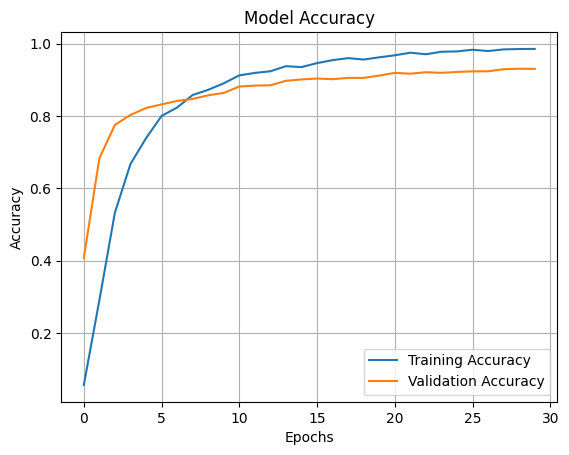

In [6]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid()
plt.show()

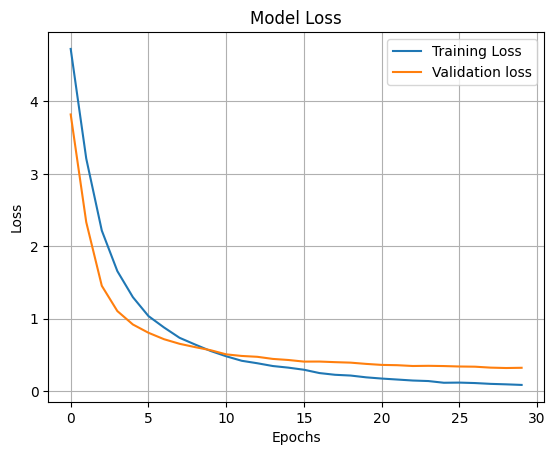

In [7]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid()
plt.show()